# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

In [1]:
# Импорт необходимых библиотек для дальнейщего анализа данных: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [2]:
# импорт библиотек ML
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

In [3]:
# Изменим настройки отображения количества строк и столбцов исходя из размера датафреймов
pd.set_option("max_rows", 151)
pd.set_option("max_columns", 20)

In [4]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError as err:
    print ('Упс! Нет данных по адресу:', err)
    df = pd.read_csv('autos.csv')

In [5]:
# Данные обучающей выборки
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [6]:
# Количество строк в исходных данных
initial_row_qnt = df.shape[0]

In [7]:
# Оценика содержание датафрейма
df.head(60)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<b> Признаки </b>  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
<b>Целевой признак </b>  
Price — цена (евро)

### Предварительная обработка данных

Убирем дублирующиеся строки

In [8]:
#Найдем общее количество дубликатов
df.duplicated().sum()

4

In [9]:
# Удалим повторяющиеся данные
df = df.drop_duplicates().reset_index(drop = True)

#### Предобработка признаков даты и времени

Произведем предобработку данных касающихся признаков даты и времени

Изменим формат даты/времени для признаков "DateCrawled", 'DateCreated', "LastSeen" и "RegistrationYear"

In [10]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

In [11]:
df['RegistrationYear'].value_counts().sort_values(ascending = False)

2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
2003    19762
2004    19611
2002    19091
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
2018     3959
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
1988      942
1985      756
1987      667
1980      588
1986      538
1983      430
1984      399
1970      333
1982      316
1978      285
1979      283
1981      263
1972      213
1960      188
1976      175
1977      173
1973      173
1974      169
1971      167
1975      143
1969      118
1966      113
1968      108
1910      101
1967       99
1965       82
1964       64
1963       57
1962       46
1961       41
1000       37
1959       32
1956       27
9999       26
2019       25
1958       25
1950       18
5000       17
1955       15
1953       14
1957       13
1951  

Автомобили с возростом более 40 лет считаются раритетными, оценки их стоимости является сложным мероприятием сильно зависящем от технического состояния, желаний владельца и покупателя и других признаков не приведенных в текущих данных. Для таких авто возможно имеет смысл создать еще одну модель, которая будет работь с авто возрастом более 25 лет. Поэтому исключим атомобили с годом регистрации автомобиля ранее 1976г. Так же исключим все значения больше 2019 года. Вероятно 8000 можно заменить на 1980, но во первых это не совсем точно, а во вторых нет смысла бороться за единичные объекты на фоне более чем достаточной по объему выборки.

In [12]:
df = df.loc[(df['RegistrationYear'] >= 1976) & (df['RegistrationYear'] <= 2016)]

In [13]:
df['RegistrationMonth'].value_counts().sort_values(ascending = False)

0     33032
3     32982
6     30186
4     28019
5     27957
7     25981
10    25171
12    23344
11    23316
9     22978
1     22189
8     21722
2     20422
Name: RegistrationMonth, dtype: int64

Нулевой месяц заменим на первый, так как все-таки принято возраст авто считать годами, то есть авто зарегистрированое в декабре по пришествию нового года добавляет к своему возрасту 1 год.

In [14]:
df['RegistrationMonth'] = df['RegistrationMonth'].replace([0], 1)    
df['RegistrationMonth'].value_counts().sort_values(ascending = False)

1     55221
3     32982
6     30186
4     28019
5     27957
7     25981
10    25171
12    23344
11    23316
9     22978
8     21722
2     20422
Name: RegistrationMonth, dtype: int64

Объедимим два столбца, год и месяц регистрации в один столбец, так как данные признаки являются по сути одним, а именно датой регистрации

In [15]:
df['reg_dt'] = df['RegistrationYear'].astype(str) + '_' + df['RegistrationMonth'].astype(str)
df['reg_dt'] = pd.to_datetime(df['reg_dt'], format = '%Y_%m')

In [16]:
# Удалим теперь уже не нужные столбцы с годом и месяцем регистрации по отдельности.
df = df.drop(['RegistrationYear', 'RegistrationMonth'], axis = 1)

Еще сократим 1 признак, найдем возраст автомобиля на момент создания объявления, таким образом вместо дат регистрации автомобилия 'reg_dt' и подачи объявления DateCreated' будет один признак 'car_age' возраст машины.

In [17]:
df['car_age'] = (df['DateCreated'] - df['reg_dt']).dt.days

In [18]:
df.head()

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_dt,car_age
0,2016-03-24 11:52:17,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57,1993-01-01,8483
1,2016-03-24 10:58:45,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-05-01,1789
2,2016-03-14 12:52:21,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46,2004-08-01,4243
3,2016-03-17 16:54:04,1500,small,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2001-06-01,5403
4,2016-03-31 17:25:20,3600,small,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2008-07-01,2830


In [19]:
previous_row_qnt = initial_row_qnt

In [20]:
def df_loss(data): 
    current_row_qnt = data.shape[0]
    loss = 100 * (previous_row_qnt - current_row_qnt) / initial_row_qnt

    print('Число объектов в датафрейме:', current_row_qnt)
    print('Потери объектов в датафрейме, %:', loss)

    return current_row_qnt

In [21]:
# Найдем потери данных после очередного преобразования
previous_row_qnt = df_loss(df)

Число объектов в датафрейме: 337299
Потери объектов в датафрейме, %: 4.817012774819468


####  Предобработка количественных признаков.

In [22]:
# Количественные признаки
num_ftrs = ['Power', 'Kilometer', 'NumberOfPictures']

Целевой признак рассмотрим отдельно, немного позже. Признак 'NumberOfPictures' так же рассмотрим отдельно.

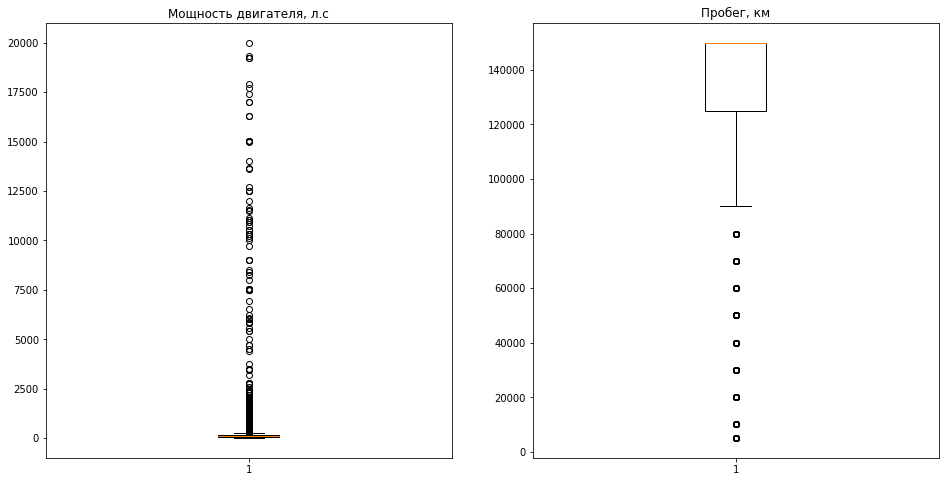

In [23]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1).set(title = 'Мощность двигателя, л.с')
plt.boxplot(df['Power'])

plt.subplot(1, 2, 2).set(title = 'Пробег, км')
plt.boxplot(df['Kilometer'])

plt.show()

In [24]:
# df.query('Power > 600').query('Power < 20000')

df.loc[(df['Power'] >= 600) & (df['Power'] <= 20000)]

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_dt,car_age
1816,2016-03-22 20:52:00,3200,small,manual,1398,corolla,5000,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26,2004-06-01,4312
2102,2016-03-21 11:55:22,0,sedan,NaN,1799,vectra,150000,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06,1999-01-01,6289
4060,2016-04-03 20:31:00,3100,sedan,manual,953,colt,150000,gasoline,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46,2005-04-01,4020
5328,2016-03-29 19:44:48,500,wagon,manual,1001,astra,150000,petrol,opel,NaN,2016-03-29,0,33154,2016-04-06 05:44:36,1999-07-01,6116
6296,2016-03-31 23:50:47,599,small,manual,603,matiz,5000,petrol,chevrolet,yes,2016-03-31,0,44379,2016-04-01 03:41:52,2002-11-01,4899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348879,2016-03-13 11:51:57,7500,sedan,manual,1548,scenic,90000,petrol,renault,NaN,2016-03-13,0,24568,2016-04-06 15:17:39,2011-04-01,1808
348964,2016-04-04 18:53:25,250,small,manual,1241,ypsilon,150000,petrol,lancia,yes,2016-04-04,0,28259,2016-04-04 18:53:25,1999-05-01,6183
351943,2016-03-07 21:36:19,1500,bus,manual,1001,zafira,5000,gasoline,opel,no,2016-03-07,0,66117,2016-03-09 12:47:08,2001-07-01,5363
353629,2016-03-23 23:55:21,2400,sedan,manual,650,c2,150000,petrol,citroen,NaN,2016-03-23,0,45277,2016-03-27 01:15:17,2007-08-01,3157


Ого! 20 000 лошадей, такому табуну позавидует любой драг кар. Но гражданскому автомобилю это многовато. Судя по всему, некоторые пользователи указывали вместо мощности объем двигателя, но такого признаки в наших данных нет. Установим максимальный порог 612 л.с. что соответствует Mercedes-Benz GLE Coupe или Audi RS Q8. Малолитражки c объемом 660 сс в датасет не попадут. Минимальный порог выберем 46 л.с. что характерно для кей каров. Таким образом избавимся и от нулевых значений заполнить которых даже на основании знания марки и модели может привести к погрешностям т.к. мощность может сильно отличаться в зависимости от комплектации. Снова посмотрим на бокс плот.  
  
Что касается пробегов, то к его значениям формально вопросов нет. Хотя отсутствие величин больше 150000 км несколько странно. Вероятно при сборе информации просто нельзя было указывать больше 150 000. А где таксисты с пробегами + 400 000 км? Но исходя из того, что ничего откорректировать здесь   мы не можем, оставим данный признак без изменений.


In [25]:
df = df.loc[(df['Power'] >= 46) & (df['Power'] <= 612)]

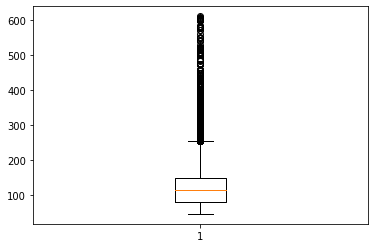

In [26]:
plt.boxplot(df['Power'])

plt.show()

Диапазон цен так же выберем из условий реальной стоимости автомобилей. Минимальным порогом выберем 100 евро, меньше это уже даром. Такие маленькие значения будут только портить реальную картину рыночной стоимости автомобиля и  обусловлены, либо ужасном состоянием, либо желанием владельца избавится от неликвида. Верхний предел неадекватных значений не имеет и ограничиваться не будет.  

In [27]:
df.query('Price > 10000').head(60)

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,reg_dt,car_age
1,2016-03-24 10:58:45,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2011-05-01,1789
8,2016-04-04 23:42:13,14500,bus,manual,125,c_max,30000,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13,2014-08-01,612
14,2016-03-21 12:57:01,17999,suv,manual,190,navara,70000,gasoline,nissan,no,2016-03-21,0,4177,2016-04-06 07:45:42,2011-03-01,1847
20,2016-04-01 19:56:48,10400,coupe,manual,160,scirocco,100000,petrol,volkswagen,no,2016-04-01,0,75365,2016-04-05 16:45:49,2009-04-01,2557
33,2016-03-25 21:48:47,18000,sedan,auto,218,3er,20000,petrol,bmw,no,2016-03-25,0,39179,2016-04-07 04:45:21,2007-05-01,3251
38,2016-04-01 17:45:07,11900,other,manual,129,other,150000,gasoline,volkswagen,no,2016-04-01,0,10551,2016-04-05 12:47:30,2002-11-01,4900
42,2016-03-24 00:52:09,12500,sedan,auto,231,5er,150000,gasoline,bmw,NaN,2016-03-23,0,46119,2016-04-04 16:18:19,2006-11-01,3430
49,2016-04-04 14:06:22,13500,bus,auto,109,b_klasse,150000,gasoline,mercedes_benz,no,2016-04-04,0,35576,2016-04-05 12:09:29,2012-07-01,1373
50,2016-03-30 08:50:37,14800,convertible,manual,170,1er,125000,petrol,bmw,NaN,2016-03-30,0,48691,2016-04-07 00:17:23,2008-04-01,2920
64,2016-03-07 22:36:54,14999,convertible,manual,218,3er,50000,petrol,bmw,no,2016-03-07,0,1129,2016-03-15 10:17:59,2007-08-01,3141


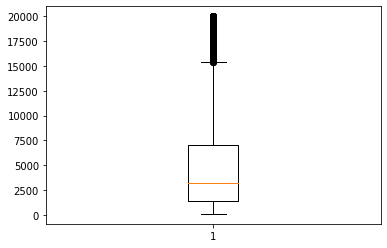

In [28]:
df = df.loc[df['Price'] >= 100]

plt.boxplot(df['Price'])

plt.show()

Рассмотри признак количества фотографий автомобиля

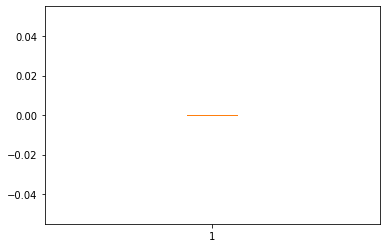

In [29]:
plt.boxplot(df['NumberOfPictures'])

plt.show()

Чтож, можно описать ситуацию, как нет данных. Везде количество картинок равно нулю. Здесь либо ошибка при передачи данных, либо фото действительно нет. Данный признак считаем абсолючтно бесполезным, его можно удалить.

In [30]:
del df['NumberOfPictures']

In [31]:
# Найдем потери данных после очередного преобразования
previous_row_qnt = df_loss(df)

Число объектов в датафрейме: 289109
Потери объектов в датафрейме, %: 13.598819309815475


####  Предобработка категориальных признаков.

Посмотрим какие типы кузовов, модели и марки представлены в нашем датафрейме, а так же варианты трансмиссий

In [32]:
df['VehicleType'].unique()

array(['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       nan, 'other'], dtype=object)

In [33]:
df['Model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'astra', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'r19', 'caddy', 'mondeo', 'cordoba', 'colt',
       'impreza', 'vectra', 'lupo', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_m

In [34]:
df['Brand'].unique()

array(['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'lancia', 'citroen', 'toyota',
       'chevrolet', 'dacia', 'suzuki', 'daihatsu', 'chrysler',
       'sonstige_autos', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'lada', 'trabant'], dtype=object)

In [35]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [36]:
df['NotRepaired'].unique()

array(['yes', nan, 'no'], dtype=object)

Общее количество пропусков

In [37]:
df.isna().mean().sort_values(ascending = False)

NotRepaired    0.141808
FuelType       0.050856
VehicleType    0.036111
Model          0.035637
Gearbox        0.016800
car_age        0.000000
reg_dt         0.000000
LastSeen       0.000000
PostalCode     0.000000
DateCreated    0.000000
Brand          0.000000
Kilometer      0.000000
Power          0.000000
Price          0.000000
DateCrawled    0.000000
dtype: float64

Пропуски в модели автомобиля и типа КПП заполнить на основании статистических данных и логических предположений без вероятности внесения существенных ошибок невозможно, поэтому данные строки придется удалить, это повлечет к потери 5% данных. Однако это необходимая мера для получения корректного датафрейма

In [38]:
df.dropna(subset = ['Gearbox','Model'], inplace = True)
df.isna().mean().sort_values(ascending = False)

NotRepaired    0.130154
FuelType       0.041386
VehicleType    0.029363
car_age        0.000000
reg_dt         0.000000
LastSeen       0.000000
PostalCode     0.000000
DateCreated    0.000000
Brand          0.000000
Kilometer      0.000000
Model          0.000000
Power          0.000000
Gearbox        0.000000
Price          0.000000
DateCrawled    0.000000
dtype: float64

In [39]:
# Найдем потери данных после очередного преобразования
previous_row_qnt = df_loss(df)

Число объектов в датафрейме: 274559
Потери объектов в датафрейме, %: 4.105889623528017


Для чистоты данных пришлось пожертвовать еще 4.6 % объема данных

<b> Заполнение неуказанных типов кузовов </b>

In [40]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

In [41]:
vehicle_type_list = df['VehicleType'].unique()
vehicle_type_list

array(['suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'coupe',
       'unknown', 'other'], dtype=object)

Для того чтобы определить неуказанный тип кузова воспользуемся статистическими данными, а именно определим наиболее часто встречаемый в данных тип кузова и присвоем его пропущенному в зависимости от модели автомобиля.

In [42]:
#  Сводная таблица для определия самого частоуказываемого типа кузова для различных моделей автомобилей
df['const'] = 1
pvt_tbl = df.pivot_table(
    'Power', 
    columns=['Model', 'VehicleType'], 
    aggfunc='count', index = ['const']
)

pvt_tbl

Model               100                             145                    \
VehicleType convertible coupe sedan unknown wagon coupe other sedan small   
const                                                                       
1                     1     2   234       9   100     1     1    12    18   

Model                ... z_reihe       zafira                              \
VehicleType unknown  ...   coupe sedan    bus coupe other sedan small suv   
const                ...                                                    
1                 2  ...      47     1   2173     1    17    15     9   4   

Model                      
VehicleType unknown wagon  
const                      
1                65   162  

[1 rows x 1264 columns]

In [43]:
# индексы объектов с неуказанным типом кузова
unknown_type_i = df.loc[df.loc[:, 'VehicleType'] == 'unknown']['VehicleType'].index

In [44]:
# Функция заполнения неуказанных типов кузовов в зависимости от модели автомобиля
def vehicle_type_def(row):
    if row['VehicleType'] == 'unknown':
        try:
            model = row['Model']
            # Найдем индекс максимально распространенного типа кузова среди данной модели
            i, = np.where(pvt_tbl[model].values[0] == pvt_tbl[model].values[0].max())
            i=i[0]
            # Присвоим название кузова 
            return pvt_tbl[model].columns[i]
        except:
            return  np.nan
    else:
        return row['VehicleType']

Заменим неуказанные типы кузовов на самые распространенные для данной модели

In [45]:
df['VehicleType'] = df.apply(vehicle_type_def, axis=1)

Вручную выборочно проверим правильность указанных кузовов

In [46]:
df.loc[unknown_type_i][['VehicleType', 'Model']]

,VehicleType,Model
31,small,clio
35,sedan,golf
52,sedan,other
71,sedan,5er
77,sedan,golf
...,...,...
354064,sedan,golf
354096,sedan,vectra
354103,sedan,golf
354111,sedan,astra


In [47]:
pvt_tbl['c4']

VehicleType,bus,coupe,other,sedan,small,suv,unknown,wagon
const,,,,,,,,
1,136,72,3,153,7,5,6,14


In [48]:
df['VehicleType'].isna().mean()

0.0

In [49]:
# Найдем потери данных после очередного преобразования
previous_row_qnt = df_loss(df)

Число объектов в датафрейме: 274559
Потери объектов в датафрейме, %: 0.0


Пропуски по типу кузова устранены без потери объектов в датафрейме

<b> Заполнение неуказанных типов топлива </b>

Посмотрим представленные типы топлива

In [50]:
df['FuelType'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Стоит учесть что 'gasoline', 'petrol' это один вид топлива, а именно бензин (источник: https://www.difference.wiki/petrol-vs-gasoline/). Возможно ошибочно под 'petrol' подразумевалось дизельное топливо, так данное тяжелое топливо не представленно в списке и это несколько странно ввиду его широкой распространености. Поэтому теоритически можно объединить  'gasoline', 'petrol' в один класс. 

Воспользуемся условием, что для различных видов топлива двигатель как правило развивает разную мощность. отсюды мы можем найти пропущенный тип топлива 

In [51]:
df['FuelType'] = df['FuelType'].fillna('unknown')

In [52]:
#  Сводная таблица для определия самого частоуказываемого типа топлива для  моделей автомобилей с различной мощьностью двигателя

pvt_tbl_fuel = df.pivot_table(
    'VehicleType', 
    columns=['Model', 'Power','FuelType'], 
    aggfunc='count', index = ['const']
)

pvt_tbl_fuel

Model       100                                                              \
Power       55       69     75       82     85     86     90     98     100   
FuelType petrol gasoline petrol gasoline petrol petrol petrol petrol petrol   
const                                                                         
1             1        1      1        1      3      2     18      2      2   

Model            ...   zafira                                                  \
Power       101  ...      192                   193 200                   239   
FuelType petrol  ... gasoline petrol unknown petrol lpg petrol unknown petrol   
const            ...                                                            
1             9  ...        1     20       1      1   3     18       1      1   

Model                   
Power       241    300  
FuelType petrol petrol  
const                   
1            11      1  

[1 rows x 13202 columns]

In [53]:
# индексы объектов с неуказанным типом топлива
unknown_fuel_i = df.loc[df.loc[:, 'FuelType'] == 'unknown']['FuelType'].index

In [54]:
# Функция заполнения неуказанных типов топлива в зависимости от модели и мощности автомобиля
def fuel_def(row):
    if row['FuelType'] == 'unknown':
        try:
            model = row['Model']
            power = row['Power']
            # Найдем индекс максимально распространенного типа кузова среди данной модели
            i, = np.where(pvt_tbl_fuel[(model, power)].values[0] == pvt_tbl_fuel[(model, power)].values[0].max())
            i=i[0]
            # Присвоим название кузова 
            return pvt_tbl_fuel[(model, power)].columns[i]
        except:
            return  np.nan
    else:
        return row['FuelType']

In [55]:
df['FuelType'] = df.apply(fuel_def, axis=1)

Вручную выборочно проверим правильность указанных типов топлива

In [56]:
df.loc[unknown_fuel_i][['FuelType', 'Model', 'Power']]

,FuelType,Model,Power
9,petrol,golf,101
13,gasoline,passat,131
36,petrol,kadett,75
41,petrol,e_klasse,306
52,petrol,other,55
...,...,...,...
354261,petrol,a4,150
354322,petrol,2_reihe,75
354323,unknown,vectra,234
354335,petrol,2_reihe,108


In [57]:
pvt_tbl_fuel[('golf',  101)]

FuelType,gasoline,lpg,petrol,unknown
const,,,,
1,660,22,1416,81


In [58]:
df.isna().mean().sort_values(ascending = False)

NotRepaired    0.130154
const          0.000000
car_age        0.000000
reg_dt         0.000000
LastSeen       0.000000
PostalCode     0.000000
DateCreated    0.000000
Brand          0.000000
FuelType       0.000000
Kilometer      0.000000
Model          0.000000
Power          0.000000
Gearbox        0.000000
VehicleType    0.000000
Price          0.000000
DateCrawled    0.000000
dtype: float64

Пропуски в признаке тип топлива устранены без потерей объектов в датафрейме

<b> Заполнение пропусков о наличии ремонта </b>

In [59]:
df['NotRepaired'].unique()

array([nan, 'no', 'yes'], dtype=object)

Пропуск о наличии ремонта это тот случай когда отсутствие информации тоже информация.  Таким образом признак 'NotRepaired' имеет 3 категории: ремонта не было, ремонт был и нет сведений. Воспользуемся техникой прямого кодирования One-Hot Encoding по отношению к 'NotRepaired'. Столбец с пропущенными значения удалим как лишний.

In [60]:
df.head(1)

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen,reg_dt,car_age,const
2,2016-03-14 12:52:21,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46,2004-08-01,4243,1


In [61]:
# заменим пропуски на 'unknown'
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

In [62]:
ohe_df = pd.get_dummies(df['NotRepaired'])

del ohe_df['unknown']

In [63]:
df = pd.concat([df, ohe_df], axis=1)
del df['NotRepaired']

In [64]:
# переименнуем столбы 
df = df.rename(columns={'no': 'not_repaired', 'yes': 'repaired'})

In [65]:
df.head(1)

,DateCrawled,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,DateCreated,PostalCode,LastSeen,reg_dt,car_age,const,not_repaired,repaired
2,2016-03-14 12:52:21,9800,suv,auto,163,grand,125000,gasoline,jeep,2016-03-14,90480,2016-04-05 12:47:46,2004-08-01,4243,1,0,0


<b> Удаление ненужных признаков </b>

Удалим ряд признаков не несущих полезной для обучения модели информации

In [66]:
df = df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'reg_dt', 'const'], axis = 1)

Переопределим порядок столбцов, на первое место вынесем столбец с целевым признаком, затем численные признаки и в конце категориальные.

In [67]:
df = df[['Price','Power','Kilometer','car_age','VehicleType','Gearbox','Model','FuelType','Brand','not_repaired','repaired']]

Проверим на наличие пропусков в оставшихся признаках

In [68]:
df.isna().mean().sort_values(ascending = False)

repaired        0.0
not_repaired    0.0
Brand           0.0
FuelType        0.0
Model           0.0
Gearbox         0.0
VehicleType     0.0
car_age         0.0
Kilometer       0.0
Power           0.0
Price           0.0
dtype: float64

In [69]:
loss = 100 * (initial_row_qnt - df.shape[0]) / initial_row_qnt

print('Число объектов в датафрейме:', df.shape[0])
print('Потери объектов в датафрейме, %:', loss)

Число объектов в датафрейме: 274559
Потери объектов в датафрейме, %: 22.52172170816296


Удаление пропусков, которые не представлялось заполнить, неадекватных значений и выбросов привели к уменьшению датафрейма на 20% . Однако учитывая большой объем объектов в данных считаем эти потери приемлемыми. Так же удалены признаки не несущие полезной информации. 

#### OHE

In [70]:
# Разделим данные  на целевой признак и остальные признаки
features = df.drop(['Price'], axis=1)
target = df['Price']

Скопируем признаки, которые будем использовать в дальнейшем для модели CatBoost 

In [71]:
cat_features = features.copy()

Для пременения данных в обучении модели LightGBM, применим OHE метод для преобразования данных в разряженную матрицу.

In [72]:
# Избавимся от предупреждения о изменение исходных данных в датафрейме.
pd.options.mode.chained_assignment = None

In [73]:
features = pd.get_dummies(
    features, 
    columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'not_repaired', 'repaired'], 
    drop_first=True
)

Разделим исходные данные на 3 выборки: обучающая, валидационная, тестовая в пропорции 60:20:20

In [74]:
# Получим валидационный и обучающий наборы данных

features_train, features_valid, target_train, target_valid  = train_test_split(
features, target, test_size=0.25, random_state=12345)

# Выделим из вариационной выборки тестовую
features_valid, features_test, target_valid, target_test = train_test_split(
features_valid, target_valid, test_size=0.5, random_state=12345)

# Проверим разделение исходных данных
print('Размер обучающего набора признаков:',  features_train.shape)
print('Размер валидационного набора признаков:',  features_valid.shape)
print('Размер тестового набора признаков:',  features_test.shape)

Размер обучающего набора признаков: (205919, 306)
Размер валидационного набора признаков: (34320, 306)
Размер тестового набора признаков: (34320, 306)


#### Ordinal encoding

Применение "горячего кодирование" привело к значительному увеличению столбцов, что создает нагружает память и может создать проблемы при создании моделей на основе дерева решений, поэтому паралельно рассмотрим порядковое и двоичное кодирование.  

Сделаем копию признаков для дальнейшего преобразование методом ordinal encoder. 

In [75]:
oe_features = cat_features.copy()

Подготовим кодировщик

In [76]:
enc = OrdinalEncoder()
enc.fit(oe_features[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

Преобразуем признаки

In [77]:
oe_features[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']] = (
    enc.transform(df[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']])
)

In [78]:
oe_features.head()

,Power,Kilometer,car_age,VehicleType,Gearbox,Model,FuelType,Brand,not_repaired,repaired
2,163,125000,4243,6.0,0.0,117.0,2.0,14.0,0,0
3,75,150000,5403,5.0,1.0,116.0,6.0,37.0,1,0
4,69,90000,2830,5.0,1.0,101.0,2.0,31.0,1,0
5,102,150000,7491,4.0,1.0,11.0,6.0,2.0,0,1
6,109,150000,4261,1.0,1.0,8.0,6.0,25.0,1,0


In [79]:
# Получим валидационный и обучающий наборы данных

oe_features_train, oe_features_valid, oe_target_train, oe_target_valid  = train_test_split(
oe_features, target, test_size=0.25, random_state=12345)

# Выделим из вариационной выборки тестовую
oe_features_valid, oe_features_test, oe_target_valid, oe_target_test = train_test_split(
oe_features_valid, oe_target_valid, test_size=0.5, random_state=12345)

# Проверим разделение исходных данных
print('Размер обучающего набора признаков:',  oe_features_train.shape)
print('Размер валидационного набора признаков:',  oe_features_valid.shape)
print('Размер тестового набора признаков:',  oe_features_test.shape)

Размер обучающего набора признаков: (205919, 10)
Размер валидационного набора признаков: (34320, 10)
Размер тестового набора признаков: (34320, 10)


<b> Маштабирование

Выделим численные признаки нуждающиеся в маштабирование.

In [80]:
# Численные признаки
numeric = ['Power', 'Kilometer', 'car_age']

In [81]:
# Настроим структуру для масштабирования признаков 
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [82]:
# Произведем маштабирование
# features_train[numeric] = scaler.transform(features_train[numeric])
# features_valid[numeric] = scaler.transform(features_valid[numeric])
# features_valid[numeric] = scaler.transform(features_test[numeric])

In [83]:
# features_train.loc[:320081, numeric]

#### Заключение по предобработек данных

Произведена предобработка данных, были удалены неадекватные величины, пропуски частично заполнены, частично удалены. в итоге суммарная потеря датафрейма при удалении составила 20 % объектов, что, как и указывалось выше считается приемлемым. Так же удалены признаки объективно не оказывающих влияния на целевой признак, что должно сократить время обучения, так ка уменьшиться сложность модели. Категориальные признаки представлены разряженной матрицей для дальнейшей работы в библиотеки в библиотеки LightGBM. В итоге считаем данные готовыми к использованию в обучении моделей.

## Обучение моделей

Согласно ТЗ модель будм строить методами библиотеки LightGBM. Но для оценки качества работы модели воспользуемя моделью построенную с использованием CatBoost. Большенство гиперпараметров оставим по умолчанию, изменим только iterations и learning_rate с целью сокращения времени обцчени. В качестве loss_function выбирем RMSE в соответствии с ТЗ.

### Константная модель

В качестве константной модели выберем медианное значение стоимости автомобиля на тренировочной выборке. Выбор медианного значения обусловлен наименьшей ошибкой предсказаний среди константных моделей. 

In [84]:
target_train.median()

3300.0

In [85]:
dummy_model = DummyRegressor(strategy="median")

In [86]:
dummy_model.fit(features_train, target_train)

DummyRegressor(constant=None, quantile=None, strategy='median')

In [87]:
%%time
y_pred = dummy_model.predict(features_valid)

CPU times: user 349 µs, sys: 36 µs, total: 385 µs
Wall time: 392 µs


In [88]:
rmse_dummy = mean_squared_error(target_valid, y_pred)
rmse_dummy

24395333.723018646

Для более наглядного понимая величины ошибки введем MAE – среднюю абсолютную ошибку. Данная метрика более интерпритируема и ясная для человека, а так же покажем ее значение отностельно медианной стоимости автомобиля

Функция для рассчета необходимых метрик

In [89]:
def get_metrics(target, pred):
    
    rmse = mean_squared_error(target, pred)
    print('Среднеквадратичная ошибка', rmse)
    
    mae = mean_absolute_error(target, pred)
    print('Среднее ошибка', mae)
    
    mae_pct = mae * 100 / target.median()
    print('Среднее относительная ошибка, %', mae_pct)
    
    return rmse, mae, mae_pct

In [90]:
rmse_dummy, mae_dummy, mae_dummy_pct =  get_metrics(target_valid, y_pred)

Среднеквадратичная ошибка 24395333.723018646
Среднее ошибка 3445.766666666667
Среднее относительная ошибка, % 103.13578768831688


<b> Вывод </b>
    
Величина погрешности констатной модели слишком велика для реального применения, но она дает общую картину возможных предсказаний и позволяет лучше ориентироваться в метриках при настройке моделей.    

### Catboost модель

Константная модель дает весьма примерные значения для метрик. Для того что бы лучше определить значения к которым нужно стремиться создадим модель CatBoost и обучим ее на дефолтных настройках. Изменим лишь количество итераций для уменьшения времени обучения. Для обучения этой модели будем использовать данные до OHE и масштабирования. 

In [91]:
# Получим валидационный и обучающий наборы данных

cat_features_train, cat_features_valid, cat_target_train, cat_target_valid  = train_test_split(
cat_features, target, test_size=0.25, random_state=12345)

# Выделим из вариационной выборки тестовую
cat_features_valid, cat_features_test, cat_target_valid, cat_target_test = train_test_split(
cat_features_valid, cat_target_valid, test_size=0.5, random_state=12345)

# Проверим разделение исходных данных
print('Размер обучающего набора признаков:',  features_train.shape)
print('Размер валидационного набора признаков:',  features_valid.shape)
print('Размер тестового набора признаков:',  features_test.shape)

Размер обучающего набора признаков: (205919, 306)
Размер валидационного набора признаков: (34320, 306)
Размер тестового набора признаков: (34320, 306)


In [92]:
cat_features_train.head(1)

,Power,Kilometer,car_age,VehicleType,Gearbox,Model,FuelType,Brand,not_repaired,repaired
222967,116,150000,9265,sedan,manual,100,petrol,audi,1,0


In [93]:
range(4)

range(0, 4)

In [94]:
# Перечислим категориальные признаки
categ_features = [i for i in range(3, 10)]

In [95]:
#  Инициируем модель
cat_model = CatBoostRegressor(
    iterations=85,
    learning_rate=0.1,
    loss_function='RMSE'
)


In [96]:
start_time = timeit.default_timer() # Время начала обучения модели 


cat_model.fit(
    cat_features_train, cat_target_train,
    cat_features=categ_features,
    eval_set=(cat_features_valid, cat_target_valid),
    verbose=5,
#     plot=True
)

cat_ml_time = timeit.default_timer() - start_time  # Время обучения модели 
cat_ml_time

0:	learn: 4324.4521503	test: 4331.2995201	best: 4331.2995201 (0)	total: 276ms	remaining: 23.1s
5:	learn: 3241.6192239	test: 3247.2856673	best: 3247.2856673 (5)	total: 1.77s	remaining: 23.3s
10:	learn: 2667.6954433	test: 2672.9688982	best: 2672.9688982 (10)	total: 3.27s	remaining: 22s
15:	learn: 2333.7527025	test: 2339.4153772	best: 2339.4153772 (15)	total: 4.67s	remaining: 20.1s
20:	learn: 2142.7823438	test: 2146.8009070	best: 2146.8009070 (20)	total: 6.06s	remaining: 18.5s
25:	learn: 2023.6713967	test: 2028.7627987	best: 2028.7627987 (25)	total: 7.45s	remaining: 16.9s
30:	learn: 1952.0347069	test: 1956.2178210	best: 1956.2178210 (30)	total: 8.76s	remaining: 15.3s
35:	learn: 1907.0118750	test: 1911.5182864	best: 1911.5182864 (35)	total: 10.1s	remaining: 13.8s
40:	learn: 1875.0679982	test: 1877.9288334	best: 1877.9288334 (40)	total: 11.4s	remaining: 12.3s
45:	learn: 1851.7885922	test: 1855.2912194	best: 1855.2912194 (45)	total: 12.9s	remaining: 11s
50:	learn: 1832.5447041	test: 1836.572

30.42116766422987

Посмотрим на параметры обученной модели

In [97]:
print('Model is fitted: ' + str(cat_model.is_fitted()))
print('Model params:')
print(cat_model.get_params())

Model is fitted: True
Model params:
{'iterations': 85, 'learning_rate': 0.1, 'loss_function': 'RMSE'}


In [98]:
cat_pred = cat_model.predict(cat_features_valid)

Посмотрим на основные метрики качества предсказаний модели.

In [99]:
rmse_cat, mae_cat, mae_cat_pct =  get_metrics(cat_target_valid, cat_pred)

Среднеквадратичная ошибка 3095257.243063014
Среднее ошибка 1148.666366916231
Среднее относительная ошибка, % 34.38091490320955


<b> Вывод </b>
    
Модель CatBoost с параметрами по умолчанию дает неплохой результат предсказаний, который условно в 3 раза лучше по точности чем константная модель, что говорит об адекватности модели. Так как по условию ТЗ перед нами стоит задача построения модели на основе библиотеки LightGBM, то оптимизировать модель CatBoost не будем, однако полученные значения времени обучения и метрик точности будем использовать при настройке гиперпараметров модели LightGBM. 

### LightGBM модель

In [100]:
# # Отключим предупреждение warning SettingWithCopyWarning
# pd.options.mode.chained_assignment = None # default='warn'

Первую модели LightGBM обучим на дефолтных гиперпараметрах. Число деревьев возьмём равное числу итераций для CatBoost модели.

In [101]:
lgbm_model = LGBMRegressor(n_estimators=85, random_state=12345)

In [102]:
start_time = timeit.default_timer() # Время начала обучения модели 

lgbm_model.fit(features_train, target_train)

lgbm_ml_time_1st = timeit.default_timer() - start_time  # Время обучения модели 
lgbm_ml_time_1st

8.773120291531086

In [103]:
lgbm_pred = lgbm_model.predict(features_valid)

Посмотрим на основные метрики качества предсказаний модели.

In [104]:
rmse_lgbm, mae_lgbm, mae_lgbm_pct =  get_metrics(target_valid, lgbm_pred)

Среднеквадратичная ошибка 2681930.612859018
Среднее ошибка 1068.0073314048404
Среднее относительная ошибка, % 31.96669654010298


In [105]:
results = pd.DataFrame(
{'модель':['Константная', 'CatBoost', 'LightGBM'], 
'rmse':[rmse_dummy, rmse_cat, rmse_lgbm],
'mae':[mae_dummy, mae_cat, mae_lgbm], 
'mae %':[mae_dummy_pct, mae_cat_pct, mae_lgbm_pct],
'время обучения, с':[0, cat_ml_time, lgbm_ml_time_1st] 
})
results

,модель,rmse,mae,mae %,"время обучения, с"
0,Константная,2.439533e+07,3445.766667,103.135788,0.000000
1,CatBoost,3.095257e+06,1148.666367,34.380915,30.421168
2,LightGBM,2.681931e+06,1068.007331,31.966697,8.773120


С настройками "из коробки" LightGBM модель немного обошла CatBoost модель по всем метрикам, кроме времени обучения. Перейдем к более детальной настройки гиперпараметров, для получения оптимальных метрик с минимальным временем обучения.

In [106]:
reg = LGBMRegressor()

In [107]:
param_grid = {'num_leaves': [214,215,216],
              'max_depth': [22,23,24,25]}

In [108]:
# grid = GridSearchCV(reg, param_grid, cv=3)
# grid.fit(features_train, target_train)

# grid.best_params_

{'max_depth': 24, 'num_leaves': 215}

In [109]:
lgbm_model = LGBMRegressor(n_estimators=215, max_depth = 24, random_state=12345)

In [110]:
start_time = timeit.default_timer() # Время начала обучения модели 

lgbm_model.fit(features_train, target_train)

lgbm_ml_time_2nd = timeit.default_timer() - start_time  # Время обучения модели 
lgbm_ml_time_2nd

17.876324370503426

In [111]:
lgbm_pred = lgbm_model.predict(features_valid)

In [112]:
rmse_lgbm_2nd, mae_lgbm_2nd, mae_lgbm_pct_2nd =  get_metrics(target_valid, lgbm_pred)

Среднеквадратичная ошибка 2443815.1452795705
Среднее ошибка 1014.4881080950877
Среднее относительная ошибка, % 30.36480419320825


In [113]:
results = pd.DataFrame(
{'модель':['Константная', 'CatBoost', 'LightGBM', 'tuned_LightGBM'], 
'rmse':[rmse_dummy, rmse_cat, rmse_lgbm, rmse_lgbm_2nd],
'mae':[mae_dummy, mae_cat, mae_lgbm, mae_lgbm_2nd], 
'mae %':[mae_dummy_pct, mae_cat_pct, mae_lgbm_pct_2nd, mae_lgbm_pct_2nd],
'время обучения, с':[0, cat_ml_time, lgbm_ml_time_1st, lgbm_ml_time_2nd] 
})
results

,модель,rmse,mae,mae %,"время обучения, с"
0,Константная,2.439533e+07,3445.766667,103.135788,0.000000
1,CatBoost,3.095257e+06,1148.666367,34.380915,30.421168
2,LightGBM,2.681931e+06,1068.007331,30.364804,8.773120
3,tuned_LightGBM,2.443815e+06,1014.488108,30.364804,17.876324


Среднеквадратичная ошибка 2707229.8714172756  
Среднее ошибка 1043.1375912248975  
Среднее относительная ошибка, % 31.297257462493175  

### LightGBM модель обученная на признаках после ordinal encoding

При обучении модели на категориальных данных преобразованных методом ordinal encoding требуется меньшая глубина деревьев. Оптимально число листов осталось прежним.

{'max_depth': 20, 'num_leaves': 215}

In [114]:
oe_lgbm_model = LGBMRegressor(n_estimators=215, max_depth = 20, random_state=12345)

In [115]:
start_time = timeit.default_timer() # Время начала обучения модели 

oe_lgbm_model.fit(oe_features_train, oe_target_train)

oe_lgbm_ml_time = timeit.default_timer() - start_time  # Время обучения модели 
oe_lgbm_ml_time

17.667030937969685

In [116]:
oe_lgbm_pred = oe_lgbm_model.predict(oe_features_valid)

In [117]:
oe_rmse_lgbm, oe_mae_lgbm, oe_mae_lgbm_pct =  get_metrics(oe_target_valid, oe_lgbm_pred)

Среднеквадратичная ошибка 2441111.8808836094
Среднее ошибка 1014.4518443730879
Среднее относительная ошибка, % 30.36371877800323


### Важности факторов

Выберем модель oe_lgbm_model, так как она обучена на признаках пред обработанных методом ordinal encoding, следовательно имеет ограниченное количество признаков (в отличии от разряженной матрицы либо после двоичного кодирования).

In [118]:
importances = oe_lgbm_model.feature_importances_

In [119]:
feature_list = list(oe_features_train.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})

Покажем важность признаков

In [120]:
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,car_age,1503
1,Power,1419
2,Model,995
3,Brand,918
4,Kilometer,594
5,VehicleType,550
6,FuelType,213
7,Gearbox,108
8,repaired,81
9,not_repaired,69


<b> Вывод </b>  
Ожидаемо важным оказался возраст автомобиля, хотя возможно это связано с отсутствием масштабирования данного признака, а вот наличие ремонта оказывается имеет весьма низкое влияние на цену. В целом требуется некоторая корректировка численных признаков.

## Анализ моделей

Для получения набора финального обучения совместим валидационную и обучающую выборки

In [121]:
final_features = pd.concat([features_train] + [features_valid])
final_target = pd.concat([target_train] + [target_valid]) 

# Для CatBoost
cat_final_features = pd.concat([cat_features_train] + [cat_features_valid])
cat_final_target = pd.concat([cat_target_train] + [cat_target_valid])   

Обучим "эталонную модель" Catboost c дефолтными параметрами на финальной выборке

In [122]:
lgbm_model = LGBMRegressor(n_estimators=215, max_depth = 24, random_state=12345)

In [123]:
start_time = timeit.default_timer() # Время начала обучения модели 


cat_model.fit(
    cat_final_features, cat_final_target,
    cat_features=categ_features,
    eval_set=(cat_features_valid, cat_target_valid),
    verbose=5,
#     plot=True
)

cat_ml_time = timeit.default_timer() - start_time  # Время обучения модели 
cat_ml_time

0:	learn: 4329.3564403	test: 4335.4669484	best: 4335.4669484 (0)	total: 226ms	remaining: 19s
5:	learn: 3244.2242970	test: 3246.3310368	best: 3246.3310368 (5)	total: 1.92s	remaining: 25.3s
10:	learn: 2654.4746732	test: 2657.0953282	best: 2657.0953282 (10)	total: 3.61s	remaining: 24.3s
15:	learn: 2322.9502651	test: 2325.5658969	best: 2325.5658969 (15)	total: 5.21s	remaining: 22.4s
20:	learn: 2139.4899951	test: 2138.6744272	best: 2138.6744272 (20)	total: 6.8s	remaining: 20.7s
25:	learn: 2017.5703460	test: 2017.4279233	best: 2017.4279233 (25)	total: 8.39s	remaining: 19s
30:	learn: 1947.1563948	test: 1946.1166534	best: 1946.1166534 (30)	total: 9.89s	remaining: 17.2s
35:	learn: 1902.1504909	test: 1901.2261076	best: 1901.2261076 (35)	total: 11.5s	remaining: 15.6s
40:	learn: 1872.8403004	test: 1872.5174636	best: 1872.5174636 (40)	total: 13s	remaining: 13.9s
45:	learn: 1847.5473016	test: 1846.6313152	best: 1846.6313152 (45)	total: 14.6s	remaining: 12.4s
50:	learn: 1828.9032346	test: 1827.461577

30.806154191493988

In [124]:
cat_pred = cat_model.predict(cat_features_test)

In [125]:
final_rmse_cat, final_mae_cat, final_mae_cat_pct =  get_metrics(cat_target_test, cat_pred)

Среднеквадратичная ошибка 2914396.668785694
Среднее ошибка 1122.5671796893141
Среднее относительная ошибка, % 33.114076097029916


Снова обучим lgbm модель на финальной выборке и посмотрим на качество ее работы натестовой выборке.

In [126]:
start_time = timeit.default_timer() # Время начала обучения модели 

lgbm_model.fit(features_train, target_train)

lgbm_ml_time_final = timeit.default_timer() - start_time  # Время обучения модели 
lgbm_ml_time_final

16.566060043871403

In [127]:
lgbm_pred = lgbm_model.predict(features_test)

In [128]:
rmse_lgbm_final, mae_lgbm_final, mae_lgbm_pct_final =  get_metrics(target_test, lgbm_pred)

Среднеквадратичная ошибка 2388168.726113846
Среднее ошибка 1001.836159434772
Среднее относительная ошибка, % 29.55268906887233


Подведем итоги проделанной работе

In [129]:
results = pd.DataFrame(
{'модель':['Константная', 'CatBoost', 'LightGBM', 'tuned_LightGBM', 'final_tuned_LightGBM', 'ordinal_encode_LightGBM'], 
'rmse':[rmse_dummy, rmse_cat, rmse_lgbm, rmse_lgbm_2nd, rmse_lgbm_final, oe_rmse_lgbm],
'mae':[mae_dummy, mae_cat, mae_lgbm, mae_lgbm_2nd, mae_lgbm_final, oe_mae_lgbm], 
'mae %':[mae_dummy_pct, mae_cat_pct, mae_lgbm_pct, mae_lgbm_pct_2nd, mae_lgbm_pct_final, oe_mae_lgbm_pct],
'время обучения, с':[0, cat_ml_time, lgbm_ml_time_1st, lgbm_ml_time_2nd, lgbm_ml_time_final,oe_lgbm_ml_time] 
})
results

,модель,rmse,mae,mae %,"время обучения, с"
0,Константная,2.439533e+07,3445.766667,103.135788,0.000000
1,CatBoost,3.095257e+06,1148.666367,34.380915,30.806154
2,LightGBM,2.681931e+06,1068.007331,31.966697,8.773120
3,tuned_LightGBM,2.443815e+06,1014.488108,30.364804,17.876324
4,final_tuned_LightGBM,2.388169e+06,1001.836159,29.552689,16.566060
5,ordinal_encode_LightGBM,2.441112e+06,1014.451844,30.363719,17.667031


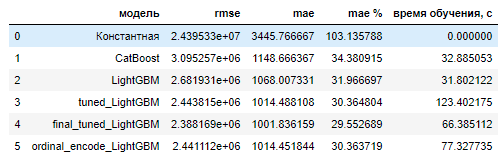

Представим гистограмму влияния признаков на величину стоимости автомобиля.

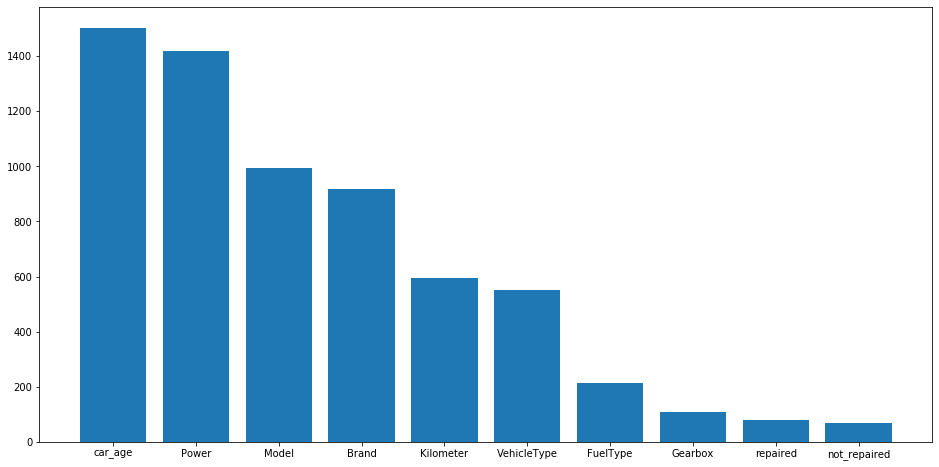

In [130]:
fig = plt.figure(figsize=(16, 8))

plt.bar(feature_results['feature'], feature_results['importance'])
plt.show()

## Вывод

Настроенная по оптимальным параметрам LGBM модель показала лучше качество работы на 7,9% по метрике RMSE, однако обучалась в 1.85 раза медленнее или на 8.64 с. дольше. Таким образом нужно уточнить на сколько для заказчика критично такое увеличение времени обучения для сравнительно не большого прироста точности работы. Возможно, обучит модель с пониженным гиперпараметрами определяющими ее сложность с целью получения меньшей времени обучения. В целом метрики LGBM модели соизмеримы несколько лучше по сравнению с эталонной моделью Catboost, что говорит о адекватной настройке модели. Так же нет существенной разнице при работе на валидационной и тестовой выборках. Таким образом считает модель обученной и готовой к дальнейшему использованию.  
  
Применение порядкового кодирования категориальных признаков позволяет уменьшить сложность модели и практически вдвое снизить время обучения, что является критичной метрикой для заказчика.  
  
На основании анализа влияния признаков можно сделать вывод, что наибольшее влияние на цену оказывает возраст автомобиля, наличие ремонта тип топлива и КПП значительно более низкую важность.